## 4. Modeling 

#### Pakete laden



In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score, f1_score,  mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import shap

import math

import xgboost as xgb
from xgboost import XGBClassifier
import sys

train_test_split

from scipy.stats import uniform, randint

#### Input: Bereinigte Daten von Data_Understanding_Preparation
Einlesen aus pickle file

In [2]:
# Der Datensatz employee_data_raw enthält den Datentyp "object", im Datensatz employee_data wurde der Datentyp "object" mittels One-Hot Encoding in Booleans umgewandelt

employee_data_raw = pd.read_pickle('../HR_Data_raw.pkl')
employee_data = pd.read_pickle('../HR_Data_One_Hot_Encoded.pkl')

Überprüfen ob die Spalten und Daten wie erwartet bereinigt sind. 

In [3]:
employee_data.tail()

,Attrition,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
1465,No,36,23,2,3,4,2,4,2571,4,...,False,False,False,False,False,False,True,False,True,False
1466,No,39,6,1,4,2,3,1,9991,4,...,False,False,False,False,False,False,True,False,True,False
1467,No,27,4,3,2,4,2,2,6142,1,...,True,False,False,False,False,False,True,False,False,True
1468,No,49,2,3,4,2,2,2,5390,2,...,False,False,False,True,False,False,True,False,True,False
1469,No,34,8,3,2,4,2,3,4404,2,...,False,False,False,False,False,False,True,False,True,False


In [4]:
#Aufteilen der Daten in Zielvariable X und Attribute Y.
X = employee_data.drop('Attrition', axis=1)
y = employee_data.Attrition

#Aufteilen der Daten in Test und Trainingsdaten.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2,
                                                    stratify=y)

Es wird die Standardtestgröße von 25% gewhält. 
Da es sich im HR Datenset um ein unbalanciertes Datenset handeln, wird mithilfe von "stratify" sichergestellt, dass die Verteilung der Attrition Werte im Test und Trainingsdatenset nahezu gleich ist. 

In [5]:
stay = (y_train.value_counts().iloc[0] / y_train.shape)[0]
leave = (y_train.value_counts().iloc[1] / y_train.shape)[0]

print("===============TRAIN=================")
print(f"Staying Rate: {stay * 100:.2f}%")
print(f"Leaving Rate: {leave * 100 :.2f}%")

stay = (y_test.value_counts().iloc[0] / y_test.shape)[0]
leave = (y_test.value_counts().iloc[1] / y_test.shape)[0]

print("===============TEST=================")
print(f"Staying Rate: {stay * 100:.2f}%")
print(f"Leaving Rate: {leave * 100 :.2f}%")

===============TRAIN=================
Staying Rate: 83.85%
Leaving Rate: 16.15%
===============TEST=================
Staying Rate: 83.97%
Leaving Rate: 16.03%


In [6]:
# Funktion zum Evaluieren der verschiedenen Modelle
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True, zero_division=0))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True, zero_division=0))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

#### 1. Decision Trees und Random Forest

#### 2. XGBoost

Ein weiterer, auf Entscheidungsbäume basierender Lernalgorithmus ist der sogenannte XGBoost (eXtreme Gradient Boosting). XGBoost unterstützt sowohl die Lösung von Klassifikations- als auch Regressionsaufgaben. Ähnlich dem Random Forest Algorithmus wird die Vorhersagegenauigkeit durch Kombination verschiedener Entscheidungsbäume erhöht, allerdings werden diese nicht unabhängig voneinander erstellt. Zur schrittweisen Verbesserung der Modelle auf Basis der Residuen nutzt XGBoost Gradient Boosting. So wird die Verlustfunktion während des Trainingsprozesses optimiert. Der Algorithmus bietet außerdem zahlreiche Hyperparameter zur Verbesserung der Modellleistung. Darunter auch Regularisierungstechniken wie L1- und L2 um Overfitting zu vermeiden und die Modellkompelxität zu kontrollieren. Nebst Anpassungsmöglichkeiten liegen die Stärken von XGBoost vor allem in der Parallelisierung und somit im effizienten Umgang mit großen Datensätze. Obwohl der Algorithmus Mechanismen zur Reduzierung von Overfitting bietet, kann die Vielschichtigkeit des Hyperparameter-Tunings dennoch zu Überanpassung führen. Außerdem ist die Interpretierbarkeit aufgrund der Komplexität eingeschränkt (Chen et al. 2014).

##### 2.1 Daten für das Training vorbereiten:

1. Zielvariable zunächst als "category" und dann in numerische Werte (binär in 0 und 1) umwandeln.

In [7]:
# Erstellen und Trainieren des XGBoost Modells

# 1. Zielvariable in numerische Codes umwandeln (Yes --> 1, No --> 0)
if y_train.dtype == 'object':
    y_train = y_train.astype('category')
    y_train = y_train.cat.codes

if y_test.dtype == 'object':
    y_test = y_test.astype('category')
    y_test = y_test.cat.codes


##### 2.2 Hyperparameter definieren und Modell trainieren:

Zur Festlegung der Hyperparameter stehen unterschiedliche Ansätze zur Verfügung. Darunter **Grid Search** und **Random Search** (s. Gliederungspunkt 2.3)
Zunächst wird das Modell allerdings nur mit den folgenden 5 Parametern trainiert, die auf einen Standard-Wert festgelgt werden:

- *"objective"*: binäres Klassifikationsproblem mit einer logistischen Regression.
- *"max_depth"*: Maximale Tiefe jedes Entscheidungsbaum. Ein höherer Wert ermöglich komplexere Werte (Achtung: Overfitting).
- *"learning_rate"*: legt die Lernrate fest und steuert die Schrittweite des Gradientabstiegs.Ziel des Gradientenabstiegs ist das Finden der optimalen Werte der Modellparameter zur Minimierung der **Loss Function** (Misst Fehler zwischen vorhergesagten und tatsächlichen Werten, z.B. Mean Squared Error bei linearen Regression oder Log-Loss bei binären Klassifikation). Ein niedriger Werte macht Modell robust ggü. Overfitting (Achtung: mehr Iterationen nötig).
- *"n_estimators"*: Anzahl der Boosting-Runden. Jede Boosting-Runde (sequenzielles Training) fügt neuen Entscheidungsbaum hinzu und korrigiert die Fehler (Residuen) des vorherigen Baumes. Idee: Kombination vieler schwacher Modelle ergibt starkes Lernmodell.
- *"eval_metric"*: Metrik zur Evaluierung des Modells. "logloss" steht für logarithmischer Verlust (Logarithmic Loss) und bewertet wie gut das Klassifikationsmodell Wahrscheinlichkeiten für die Klassen vorhersagt. Beispiel einer "guten" Vorhersage: Tatsächliches Label ist 1 und Modell sagt Wahrscheinlichkeit von 0,9 vorher. Dann ist Log Loss relativ klein. Hier wird "logloss" als Evaluationsmetrik verwendet um Leistung des Modells während des Trainings zu bewerten (Ziel: Minimierung des logarithmischen Verlustes).


In [8]:
# Erstellen und Trainieren des XGBoost-Modells mit XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic', max_depth=6, learning_rate=0.3, n_estimators=100, eval_metric='logloss')
# xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Vorhersagen mit dem Modell
xgb_preds = xgb_model.predict(X_test)
xgb_y_pred = (xgb_preds > 0.5).astype(int)


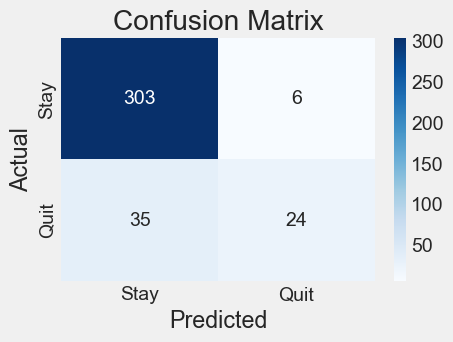

In [9]:
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(4.5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Quit'], yticklabels=['Stay', 'Quit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [10]:
evaluate(xgb_model, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[924   0]
 [  0 178]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    924.0  178.0       1.0     1102.0        1102.0
TESTING RESULTS: 
CONFUSION MATRIX:
[[303   6]
 [ 35  24]]
ACCURACY SCORE:
0.8886
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.896450   0.800000  0.888587    0.848225      0.880986
recall       0.980583   0.406780  0.888587    0.693681      0.888587
f1-score     0.936631   0.539326  0.888587    0.737978      0.872932
support    309.000000  59.000000  0.888587  368.000000    368.000000


##### 2.3 Hyperparameter Tuning

Mit Hilfe von GridSearchCV kann aus einer Auswahl von Parametern die ideale Kombination ermittelt werden. 
Durch Verwendung von RandomSearchCV kann durch die Festlegung von Iterationen eine zufällig ideale Parameterkombination ermittelt werden.

- *max_depth:* Steuert, wie tief jeder einzelne Entscheidungsbaum wachsen kann. Größere Werte können zu komplexeren Modellen führen.
- *learning_rate (eta):* Kleinere Werte machen das Training langsamer, aber stabiler. Ein niedrigerer Wert erfordert oft mehr n_estimators.
- *n_estimators:* Gibt an, wie viele Bäume im Modell trainiert werden. Mehr Bäume können zu besseren Modellen führen, aber auch die Rechenzeit erhöhen.
- *subsample:* Der Anteil der Trainingsdaten, die für jede Boosting-Runde zufällig ausgewählt werden. Reduziert Overfitting, Werte zwischen 0.5 und 1.0 sind üblich.
- *colsample_bytree:* Der Anteil der Merkmale, die für das Training jedes Baumes zufällig ausgewählt werden. Reduziert Overfitting, indem es die Vielfalt der Bäume erhöht. Werte zwischen 0.5 und 1.0 sind üblich.
- *reg_alpha (alpha):* L1-Regularisierungsterm, der eine Strafe für die Summe der absoluten Werte der Koeffizienten hinzufügt. Fördert Sparsamkeit im Modell, indem es einige Koeffizienten auf genau Null setzt, was effektiv einer Feature-Auswahl entspricht und Overfitting reduziert.
- *reg_lambda (lambda):* L2-Regularisierungsterm, der eine Strafe für die Summe der Quadrate der Koeffizienten hinzufügt. Stabilisiert das Modell, indem es alle Koeffizienten schrumpft, um Überanpassung zu reduzieren, ohne sie auf Null zu setzen, was zu einem glatteren und weniger komplexen Modell führt.
- *gamma:* Mindesteste Verlustreduktion, die erforderlich ist, um eine Baumaufspaltung durchzuführen. Höhere Werte führen dazu, dass weniger Splits durchgeführt werden, was zu einfacheren und weniger overfitted Modellen führt.

In [59]:
# Random Search: Definiere Parametergrenzen
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'scale_pos_weight': randint(1, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# RandomizedSearchCV starten, n_iter gibt an, wieviele Iterationen durchgeführt werden
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=1,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

print(f"Best Parameter: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameter: {'colsample_bytree': 0.5318264513359677, 'learning_rate': 0.06466803379261947, 'max_depth': 5, 'n_estimators': 195, 'reg_alpha': 0.5509482191178968, 'reg_lambda': 0.7453344309065021, 'scale_pos_weight': 2, 'subsample': 0.2649195576628094}
Best Score: 0.8765919322355171


Es wurden verschiedene Parameterkonfigurationen getestet. Dabei wurde nie ein besserer Score erreicht als mit den Standardparametern.

##### 2.4 Visualisierung der Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

In [19]:
# Berechnen der FPR, TPR und AUC
fpr_xgb_model, tpr_xgb_model, _ = roc_curve(y_test, xgb_preds)
roc_auc_xgb_model = roc_auc_score(y_test, xgb_preds)

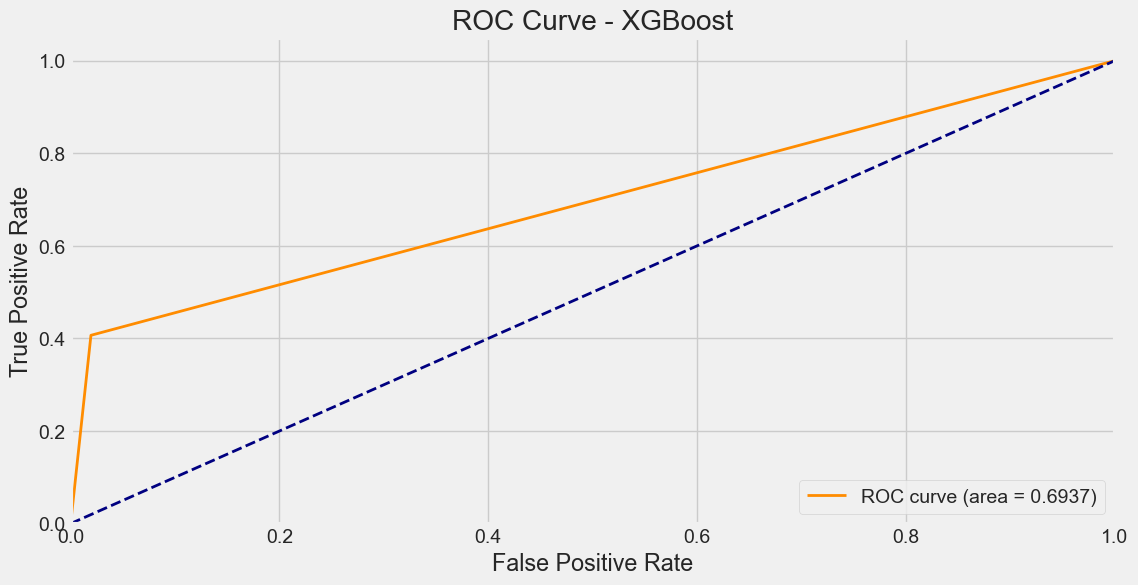

In [20]:
# Plotten der ROC-Kurve für XGBoost
plt.figure(figsize=(12, 6))
plt.plot(fpr_xgb_model, tpr_xgb_model, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb_model:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")

##### 2.5 Vergleich Modell-Performance mit Originaldaten vs. bereinigte Daten (One-Hot-Encoding)

Verbessert sich die ROC-Curve, wenn XGBoost auf den Originaldaten (Kategoriale Variablen) anstatt auf den mittels One-Hot Encoding bereinigten Daten ausgeführt wird?

In [24]:
#Aufteilen der Daten in Zielvariable X und Attribute Y.
X_raw = employee_data_raw.drop('Attrition', axis=1)
y_raw = employee_data_raw.Attrition

#Aufteilen der Daten in Test und Trainingsdaten.
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.25, random_state=2)

# Textfeatures in Kategorien umwandeln
categories = X_train_raw.select_dtypes(include=object).columns.tolist()
for col in categories:
    X_train_raw[col] = X_train_raw[col].astype('category')
    X_test_raw[col] = X_test_raw[col].astype('category')

# Labels in numerische Codes umwandeln
if y_train_raw.dtype == 'object':
    y_train_raw = y_train_raw.astype('category')
    y_train_raw = y_train_raw.cat.codes

if y_test_raw.dtype == 'object':
    y_test_raw = y_test_raw.astype('category')
    y_test_raw = y_test_raw.cat.codes

# Erstellen der DMatrix
# DMatrix ist eine spezielle Datenstruktur, die von XGBoost verwendet wird.
# "enable_categorial=True" ermöglich die Verarbeitung kategorialer Daten

dtrain_reg = xgb.DMatrix(X_train_raw, y_train_raw, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test_raw, y_test_raw, enable_categorical=True)

# Modell trainieren

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'logloss'
}
xgb_model_raw = xgb.train(params, dtrain_reg, num_boost_round=100)

In [26]:
# Vorhersagen
y_pred_prob_raw = xgb_model_raw.predict(dtest_reg)
y_pred_raw = (y_pred_prob_raw > 0.5).astype(int)


# Genauigkeit berechnen
accuracy = accuracy_score(y_test_raw, y_pred_raw)
mse = mean_squared_error(y_test_raw, y_pred_prob_raw)
rmse = np.sqrt(mse)
auc = roc_auc_score(y_test_raw, y_pred_prob_raw) 
fpr, tpr, _ = roc_curve(y_test_raw, y_pred_prob_raw)

print(f"Accuracy: {accuracy}")
print(f"mse: {mse}")
print(f"rmse: {rmse}")
print(f"Area under Curve: {auc}")

Accuracy: 0.8586956521739131
mse: 0.11906321346759796
rmse: 0.34505537152290344
Area under Curve: 0.8007590132827325


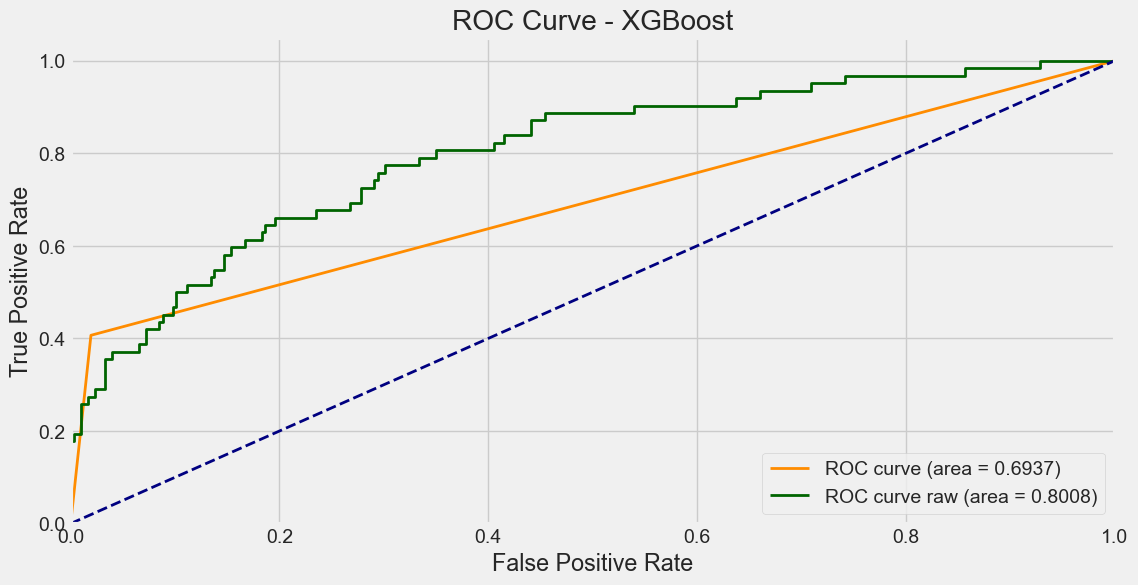

In [27]:
# Plotten der ROC-Kurve für XGBoost
plt.figure(figsize=(12, 6))
plt.plot(fpr_xgb_model, tpr_xgb_model, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb_model:0.4f})')
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve raw (area = {auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")

#### 3. SVM

Die Support Vector Machine (SVM) ist ein überwachter Lernalgorithmus, der versucht das Risiko von Overfitting zu verringern. Bei der SVM wird jedes Mitglied des Trainingsdatensatzes einer vor zwei Kategorien zugewiesen, sodass es sich um einen nicht-probabilistischen binären linearen Klassifikator handelt. Bei einer linearen Klassifikation werden die Eingabetrainingsdatenpunkte in einem Raum (Hyperplane) abgebildet, jeder mit einem anderen Klassenlabel, das durch eine klare Lücke voneinander getrennt ist. Neue Datenpunkte werden dann in denselben Raum abgebildet und als Teil einer Klasse vorhergesagt, je nachdem, auf welcher Seite der Lücke sie liegen. SVM kann aber auch nicht-lineare Klassifikationen durchführen. Nebst der Robustheit gegenüber Überanpassung liegt der Vorteil in der Effektivität in hochdimensionalen Räumen (also wenn die Anzahl der Merkmale größer als die Anzahl an Beobachtungen ist). Durch verschiedene Kernel-Funktionen (darunter linear, polynominal und sigmoid) sind SVMs flexibel auf verschiedene Datensätze und Problemtypen einsetzbar. Allerdings gestaltet sich die Modellauswahl mitunter durch das Hyperparameter-Tuning und die Kernel-Auswahl als komplex. Unter der Modellkomplexität leidet ebenfalls die Interpretierbarkeit (Cortes und Vapnik 1995).

In [14]:
# Erstellen und trainieren des SVM Modells 
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=2)
svm.fit(X_train, y_train)
evaluate(svm, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[924   0]
 [178   0]]
ACCURACY SCORE:
0.8385
CLASSIFICATION REPORT:
                    0      1  accuracy    macro avg  weighted avg
precision    0.838475    0.0  0.838475     0.419238      0.703041
recall       1.000000    0.0  0.838475     0.500000      0.838475
f1-score     0.912142    0.0  0.838475     0.456071      0.764809
support    924.000000  178.0  0.838475  1102.000000   1102.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[309   0]
 [ 59   0]]
ACCURACY SCORE:
0.8397
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.839674   0.0  0.839674    0.419837      0.705052
recall       1.000000   0.0  0.839674    0.500000      0.839674
f1-score     0.912851   0.0  0.839674    0.456425      0.766497
support    309.000000  59.0  0.839674  368.000000    368.000000


Mithilfe von GridSearch wird eine geeignete Parameterkombination identifiziert. 

In [15]:
svm = SVC(random_state=2)

param_grid = [
    {'C': [0.1, 1, 6, 10], 'gamma': [0.001, 0.005, 0.01], 'kernel': ['rbf']},
]


search = GridSearchCV(svm, param_grid=param_grid, scoring='roc_auc', cv=3, refit=True, verbose=1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(random_state=2),
             param_grid=[{'C': [0.1, 1, 6, 10], 'gamma': [0.001, 0.005, 0.01],
                          'kernel': ['rbf']}],
             scoring='roc_auc', verbose=1)

Bei mehrmaligem Testen mit unterschiedlichen RandomStates wird deutlich, dass die geeigneten Parameterkombinationen stark voneinander abweichen. 

In [16]:
svm = SVC(**search.best_params_, probability=True)
svm.fit(X_train, y_train)

evaluate(svm, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[924   0]
 [178   0]]
ACCURACY SCORE:
0.8385
CLASSIFICATION REPORT:
                    0      1  accuracy    macro avg  weighted avg
precision    0.838475    0.0  0.838475     0.419238      0.703041
recall       1.000000    0.0  0.838475     0.500000      0.838475
f1-score     0.912142    0.0  0.838475     0.456071      0.764809
support    924.000000  178.0  0.838475  1102.000000   1102.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[309   0]
 [ 59   0]]
ACCURACY SCORE:
0.8397
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.839674   0.0  0.839674    0.419837      0.705052
recall       1.000000   0.0  0.839674    0.500000      0.839674
f1-score     0.912851   0.0  0.839674    0.456425      0.766497
support    309.000000  59.0  0.839674  368.000000    368.000000


##### Visualisierung der Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

In [21]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.predict(X_test))
roc_auc_svm = roc_auc_score(y_test, svm.predict(X_test))

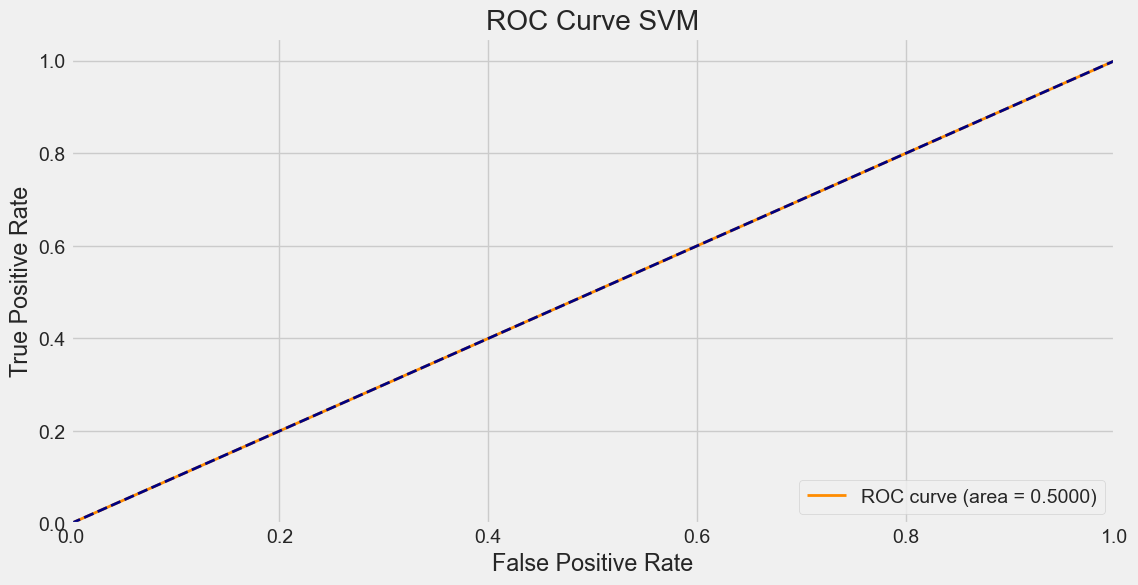

In [22]:
# Plotten der ROC-Kurve für SVM
plt.figure(figsize=(12, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc="lower right")

Um das Modell besser zu verstehen kann die Visualisierung mithilfe von SHAP und LIME durchgeführt werden. 

In [ ]:
# SHAP-Explainer für das SVM-Modell erstellen
explainer = shap.KernelExplainer(svm.predict_proba, X_train)

# SHAP-Werte für die Testdaten berechnen
shap_values = explainer.shap_values(X_test)

# SHAP-Werte visualisieren
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [ ]:
# LIME-Explainer erstellen
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   class_names=employee_data['No Attrition', 'Attrition'], 
                                                   discretize_continuous=True)

# Eine einzelne Vorhersage erklären
i = 0  # Index der zu erklärenden Instanz
exp = explainer.explain_instance(X_test.iloc[i].values, 
                                 svm_clf.predict_proba, 
                                 num_features=4)

# Visualisierung der Erklärung
exp.show_in_notebook(show_all=False)

### Vergleich der Methoden 
Im Folgenden werden die zuvor angewendeten Modelle SVM, XGBoost und Random Forest verglichen um zu bewerten, welches Modell die besten Ergebnisse liefert. 

In [ ]:
# Plotten der ROC-Kurven der verschiedenen Modelle
plt.figure(figsize=(12, 6))

# ROC-Kurve vor dem Tuning
plt.subplot(1, 3, 1)
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {auc_svm:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc="lower right")

# ROC-Kurve XGBoost
plt.subplot(1, 3, 2)
plt.plot(xxx, xxx, color='darkorange', lw=2, label=f'ROC curve (area = {xxx:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XGBoost')
plt.legend(loc="lower right")

# ROC-Kurve Random Forest
plt.subplot(1, 3, 3)
plt.plot(xxx, xxx, color='darkorange', lw=2, label=f'ROC curve (area = {xxx:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Random Forest')
plt.legend(loc="lower right")

plt.tight_layout()